# Oregon School Boards Voter Data
For this project we want to visualize voter data for the Oregon school Boards. The main attributes we want to visualize per district are:
  - Voter gender ratio
  - Voter ages
  - Total amount of voters
  - Votes per political party
  
For this, we will begin by cleaning and processing the data and finish by creating a geojson with all the necessary attributes needed as a base for a Mapbox map (see last cell for the final map).

The base datasets that we are using are:
  - `voters.csv`: This dataset contains the voter data for each school board, including total and percentage of votes for each political party, average ages, and total number of voters.
  - `genders.csv`: This dataset contains the voters' gender percentages for each district.
  - `districts.csv`: This dataset contains many attributes but we are interested with the names and GEOID of the districts. This dataset shares the same names of districts as the other datasets, so we will use it to join the GEOID to the other datasets. The GEOID is then used to join all the data into the geojson.
  - `s_districts.geojson`: This is a geojson file containing the geometries and GEOID of the school districts. The data originally comes from US Census Bureau TIGER Files. It was previously converted to geojson and projected to the EPSG 4326 CRS in order to be able to visualize it with Mapbox.

## 1. Formatting the column names
We will begin by importing the datasets and exploring the column names of each dataset in order to set them to a useable format. We will remove the percentage signs, turn all letters into lower caps, and change long names into shorter ones to make them easier to work with.

In [1]:
import pandas as pd
import inflection

voters = pd.read_csv('voters.csv')
districts = pd.read_csv('districts.csv')
gender = pd.read_csv('gender.csv')
print(gender.columns)
print(districts.columns)

print(voters.columns)
voters.columns = voters.columns.str.replace('%', 'prcnt')
voters.columns = voters.columns.str.lower()
voters.columns = voters.columns.str.replace('working_families_party', 'wfp')
voters.columns = voters.columns.str.replace('working_families party_of_oregon', 'wfp')
print("\n Formatted columns: \n",voters.columns)

Index(['district', 'fem_prcnt', 'male_prcnt'], dtype='object')
Index(['STATEFP', 'ELSDLEA', 'GEOID', 'NAME', 'LSAD', 'LOGRADE', 'HIGRADE',
       'MTFCC', 'SDTYP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'UNSDLEA', 'layer', 'path'],
      dtype='object')
Index(['district', 'avg_age', 'voter_count', 'CONSTITUTION', 'CONSTITUTION_%',
       'DEMOCRAT', 'DEMOCRAT_%', 'INDEPENDENT', 'INDEPENDENT_%', 'LIBERTARIAN',
       'LIBERTARIAN_%', 'NONAFFILIATED', 'NONAFFILIATED_%', 'OTHER', 'OTHER_%',
       'PACIFIC_GREEN', 'PACIFIC_GREEN_%', 'PROGRESSIVE', 'PROGRESSIVE_%',
       'REPUBLICAN', 'REPUBLICAN_%', 'WORKING_FAMILIES PARTY_OF_OREGON',
       'WORKING_FAMILIES_PARTY_%'],
      dtype='object')

 Formatted columns: 
 Index(['district', 'avg_age', 'voter_count', 'constitution',
       'constitution_prcnt', 'democrat', 'democrat_prcnt', 'independent',
       'independent_prcnt', 'libertarian', 'libertarian_prcnt',
       'nonaffiliated', 'nonaffiliated_prcnt', 'other', 

We can see that the formatted columns look better and will be easier to work with.

## 2. Joining the datasets
We will now join the GEOID from the `districts` dataset into the `voters` dataset. Then, we will join the gender data.

In [2]:
#converting to lower case to make sure we don't have problems with the join because of differences in caps.
districts['NAME']=districts['NAME'].str.lower() 
gender['district2'] = gender['district'].str.lower()
voters['district'] = voters['district'].str.lower()

first_join = pd.merge(voters, districts.loc[:,['GEOID','NAME']], left_on='district', right_on='NAME', how='left') #joining GEOID
joined = pd.merge(first_join, gender, left_on='district', right_on='district2', how='left') # joining gender data

joined[['district_x','GEOID','fem_prcnt','male_prcnt']].head(10) #checking that everything joined correctly

,district_x,GEOID,fem_prcnt,male_prcnt
0,adel school district 21,4100990,46.77%,53.23%
1,adrian school district 61,4101020,49.92%,50.08%
2,alsea school district 7j,4101200,47.86%,52.14%
3,amity school district 4j,4101230,50.71%,49.29%
4,annex school district 29,4101350,46.83%,53.17%
5,arlington school district 3,4101470,46.33%,53.67%
6,arock school district 81,4101500,50.63%,49.37%
7,ashland school district 5,4101560,52.90%,47.10%
8,ashwood school district 8,4101590,51.35%,48.65%
9,astoria school district 1,4101620,50.33%,49.67%


### 2.1 Checking the joins
We used left joins, so if any district from the `voters` dataset didn't have any corresponding GEOID on the `districts` dataset, we would have `NaN` values on the GEOID column. The same would happen for the gender data if it was unavailable for any district.

This means that we can check that the join worked correctly by comparing the length of the columns with the length of those columns without null values.

In [3]:
print(len(joined['GEOID']))
print(len(joined['fem_prcnt']))

196
196


In [4]:
joined['GEOID'] = joined['GEOID'].dropna()
joined['fem_prcnt'] = joined['fem_prcnt'].dropna()

print(len(joined['GEOID'])) #checking that there were no null values
print(len(joined['fem_prcnt'])) #checking that there were no null values


196
196


We can see that the length is the same for columns after attempting to remove null values. This means that there were no null values, so all values were joined for all districts.

## 3. Cleaning the data
We will now clean the columns by doing the following:
  - Remove all Null values in the numeric columns and replace them by 0
  - Remove percent signs from the values and transform those columns from object type to float type

In [5]:
cleaned = joined.drop(['NAME', 'district_y','district2'], axis=1) #removing duplicate columns that were left after the joins

In [6]:
cleaned.fillna(0, inplace=True) #Replacing null values by 0
cleaned = cleaned.replace({'\%':''}, regex = True) #removing percent signs
print(cleaned.dtypes)


district_x              object
avg_age                float64
voter_count              int64
constitution           float64
constitution_prcnt      object
democrat               float64
democrat_prcnt          object
independent            float64
independent_prcnt       object
libertarian            float64
libertarian_prcnt       object
nonaffiliated            int64
nonaffiliated_prcnt     object
other                  float64
other_prcnt             object
pacific_green          float64
pacific_green_prcnt     object
progressive            float64
progressive_prcnt       object
republican               int64
republican_prcnt        object
wfp                    float64
wfp_prcnt               object
GEOID                    int64
fem_prcnt               object
male_prcnt              object
dtype: object


We can see that there are columns that should be numeric but are of type object because they are still considered as strings.

In [7]:
not_num = cleaned.columns[(cleaned.columns != 'district_x') & (cleaned.columns != 'GEOID')] #filtering the columns that we don't need to convert to numeric
cleaned[not_num]=cleaned[not_num].apply(pd.to_numeric, downcast = 'float') #converting the columns to numeric
cleaned.dtypes

district_x              object
avg_age                float32
voter_count            float32
constitution           float32
constitution_prcnt     float32
democrat               float32
democrat_prcnt         float32
independent            float32
independent_prcnt      float32
libertarian            float32
libertarian_prcnt      float32
nonaffiliated          float32
nonaffiliated_prcnt    float32
other                  float32
other_prcnt            float32
pacific_green          float32
pacific_green_prcnt    float32
progressive            float32
progressive_prcnt      float32
republican             float32
republican_prcnt       float32
wfp                    float32
wfp_prcnt              float32
GEOID                    int64
fem_prcnt              float32
male_prcnt             float32
dtype: object

## 4. Preparing for visualization
In order to visualize the voter attributes on the map, we first need to understand how the values are distributed to decide the colors classes that will be assigned in the map.

### 4.1. Gender

In [8]:
print("Females: \n",cleaned['fem_prcnt'].describe(), "\n")
print("Males: \n",cleaned['male_prcnt'].describe(), "\n")


Females: 
 count    196.000000
mean      49.754993
std        2.158480
min       39.389999
25%       49.165000
50%       50.065001
75%       51.110001
max       53.990002
Name: fem_prcnt, dtype: float64 

Males: 
 count    196.000000
mean      50.245056
std        2.158477
min       46.009998
25%       48.889999
50%       49.934999
75%       50.835000
max       60.610001
Name: male_prcnt, dtype: float64 



We see that the percentages of male and females are always very close to 50% without too much variation. So we will have to use a very reduced range of values in the map visualization in order to see the contrast between districts.

We can also see that there maximum percentage of voters is higher for males than for females. Since we are only visualizing values above 50% for each dominant gender, the range of values to be visualized for the males `(60.61 - 50 = 10.61)` is wider than the females `(53.99 - 50 = 3.99)`. This means that we will have to use smaller steps for the classes in the female category.

### 4.2. Political party
First, we will identify the predominant party of each district and the corresponding number and percetage of votes.

In [9]:
#finding predominant party
parties = ['constitution', 'democrat', 'independent', 'libertarian', 'nonaffiliated', 'other', 'pacific_green', 'progressive', 'republican', 'wfp']
parties_prcnt = [s + "_prcnt" for s in parties]
cleaned['max_tot'] = cleaned[parties].max(axis=1).apply(round, ndigits=2) # Finding the max votes
cleaned['max_prcnt'] = cleaned[parties_prcnt].max(axis=1).apply(round,ndigits=2) # Finding the max percentage
cleaned['main_party'] = cleaned[parties].idxmax(axis=1).apply(inflection.humanize) # Saving the predominant party and formatting the text
cleaned[['max_tot', 'max_prcnt', 'main_party']].describe(include='all')

,max_tot,max_prcnt,main_party
count,196.00000,196.000000,196
unique,NaN,NaN,3
top,NaN,NaN,Nonaffiliated
freq,NaN,NaN,92
mean,6965.44898,41.959643,NaN
std,21501.80475,8.802307,NaN
min,13.00000,31.890000,NaN
25%,480.25000,36.555000,NaN
50%,1802.50000,39.515000,NaN
75%,5680.75000,44.390000,NaN


We can see that there are only 3 dominant parties. Let's see which ones those are:

In [10]:
main_parties = cleaned['main_party'].unique()
print(main_parties)

['Republican' 'Nonaffiliated' 'Democrat']


#### 4.2.1 Party colors
We will now attempt to assign colors to each predominant party. This will be more difficult to do directly with Mapbox because we are trying to visualize to attributes:
  - `main_party`: The party with the most votes on each district. The colors will be: Blue for Democrats, Red for Republicans, and Yellow for Non-affiliated.
  - `max_prcnt`: The percentage of votes for the predominant party. This attribute will define the lightness or darnkess of the colore defined by the main party. The darker the color, the higher the percentage of votes.
In order to do this, we will have to add a column to the dataframe, indicating the exact color to use for the map. To define the color we will use HSV codes (Hue, Saturation, Lightness), so that we can define the Hue based on the party and apply a formula to calculate the lightness based on the percentage of votes.

The formula for lightness is `f(x) = 130 - 1.33x`, where `x` is the percentage of votes. This was defined by knowing that the range of values to be colored will be from 30 to 60 (very few values are above 60 so the last category will be 60+), and the range of lightness values will be from 50% to 80%. The formula translates the voter percentage into a lightness value.

In [11]:
lightness =130-1.33*cleaned['max_prcnt'] #function used to calculate color lightness based on party vote percentage
cleaned.loc[cleaned['main_party']=='Republican','party_color'] = "hsl("+str(360)+","+str(100)+"%,"+lightness.loc[cleaned['main_party']=="Republican"].apply(str)+"%)" #hue property for coloring the map based on affiliations. 240 = Blue, 360 = red, 60 = yellow
cleaned.loc[cleaned['main_party']=="Democrat","party_color"] = "hsl("+str(240)+","+str(100)+"%,"+lightness.loc[cleaned['main_party']=="Democrat"].apply(str)+"%)"
cleaned.loc[cleaned['main_party']=="Nonaffiliated","party_color"] = "hsl("+str(60)+","+str(100)+"%,"+lightness.loc[cleaned['main_party']=="Nonaffiliated"].apply(str)+"%)"

cleaned['party_color']

0      hsl(360,100%,36.035499999999985%)
1                 hsl(360,100%,69.0328%)
2                 hsl(360,100%,83.8091%)
3                  hsl(60,100%,83.4367%)
4                  hsl(60,100%,67.4634%)
                     ...                
191                hsl(60,100%,72.3711%)
192      hsl(60,100%,80.25800000000001%)
193                hsl(60,100%,75.7493%)
194                hsl(360,100%,83.184%)
195               hsl(360,100%,78.2896%)
Name: party_color, Length: 196, dtype: object

### 4.3. Ages


Ages: 
 count    196.000000
mean      52.282894
std        3.498891
min       42.860001
25%       49.877501
50%       51.910000
75%       54.204999
max       65.699997
Name: avg_age, dtype: float64


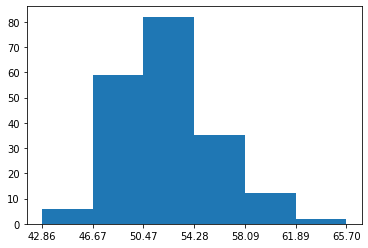

In [12]:
import matplotlib.pyplot as plt
print("Ages: \n",cleaned['avg_age'].describe())
fig, ax = plt.subplots()
counts, bins, patches =ax.hist(cleaned["avg_age"], bins=6)
ax.set_xticks(bins)
plt.show()

We can see that most voters are in the 50 - 55 year range. We wanted 6 classes so the bins are of approximately 3 years.

## 5. Creating the geoJSON

We now want to join all the data from the previous analysis into the geoJSON that contains the geometries for the districts.

For this, we will begin by importing the geoJSON into a python dictionary.

In [13]:
import json

open_geojson = open('s_districts.geojson')
geojson = open_geojson.read()
geo_dict = json.loads(geojson)

# Checking that the geojson was correctly loaded into a dictionnary:
print(type(geo_dict))
print(geo_dict.keys())
print(geo_dict['features'][0].keys())
print(geo_dict['features'][0]['properties'].keys())

<class 'dict'>
dict_keys(['type', 'name', 'crs', 'features'])
dict_keys(['type', 'properties', 'geometry'])
dict_keys(['STATEFP', 'ELSDLEA', 'GEOID', 'NAME', 'LSAD', 'LOGRADE', 'HIGRADE', 'MTFCC', 'SDTYP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'UNSDLEA', 'layer', 'path'])


### 5.1. Joining the Dataframe attributes to the dictionary

To join the data from the cleaned dataframe, we will have to iterate over the features in the dictionary and match the GEOID of each feature with the GEOID of the dataframe.

In [14]:
for index in range(len(geo_dict['features'])):
    match = cleaned['GEOID'] == pd.to_numeric(geo_dict['features'][index]['properties']['GEOID'])
    keys_to_remove = ['STATEFP', 'ELSDLEA','LSAD', 'LOGRADE', 'HIGRADE', 'MTFCC', 'SDTYP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'UNSDLEA', 'layer']
    try:
        geo_dict['features'][index]['properties'].update(cleaned.loc[match].to_dict(orient='records')[0])
        for key in keys_to_remove: #removing unnecesary fields that came from the original geoJSON
            geo_dict['features'][index]['properties'].pop(key)
    except IndexError:
        print("District '"+geo_dict['features'][index]['properties']['NAME'] + "' is not present in polygons")
print(geo_dict['features'][0]['properties'].keys())

District 'School District Not Defined' is not present in polygons
dict_keys(['GEOID', 'NAME', 'path', 'district_x', 'avg_age', 'voter_count', 'constitution', 'constitution_prcnt', 'democrat', 'democrat_prcnt', 'independent', 'independent_prcnt', 'libertarian', 'libertarian_prcnt', 'nonaffiliated', 'nonaffiliated_prcnt', 'other', 'other_prcnt', 'pacific_green', 'pacific_green_prcnt', 'progressive', 'progressive_prcnt', 'republican', 'republican_prcnt', 'wfp', 'wfp_prcnt', 'fem_prcnt', 'male_prcnt', 'max_tot', 'max_prcnt', 'main_party', 'party_color'])


In [15]:
#saving the geojson to an external file. We will use this for the map.
# you can check the code for the map at: https://github.com/rodrigomd94/oregon-school-voters

with open('districts_final.geojson', 'w') as outfile:
    json.dump(geo_dict, outfile)

## 6. Creating the map
Using the resulting geoJSON, I created a map with different layers corresponding to voters, genders, ages, and affiliations for each district. You can see the code for the map on my github: https://github.com/rodrigomd94/oregon-school-voters

In [16]:
import IPython
url = 'https://rodrigomd94.github.io/oregon-school-voters/'
IPython.display.IFrame(url, width=700, height=350)

## 6. Additional analysis of voters


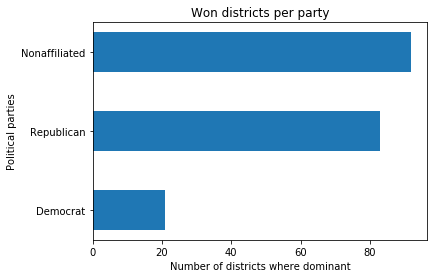

In [17]:
from numpy import arange
num_cols = ['Democrat', 'Republican', 'Nonaffiliated']
bar_widths = cleaned['main_party'].value_counts().loc[num_cols].values
bar_positions = arange(3) + 1
tick_positions = range(1,4)

fig, ax = plt.subplots()
ax.barh(bar_positions, bar_widths, 0.5)
ax.set_yticks(tick_positions)
ax.set_yticklabels(num_cols)
ax.set_xlabel("Number of districts where dominant")
ax.set_ylabel("Political parties")
plt.title("Won districts per party")
plt.show()

Non-affiliated voters have the highest amount of districts where they have the higher percentage of voters, and democrats are in the opposite end.

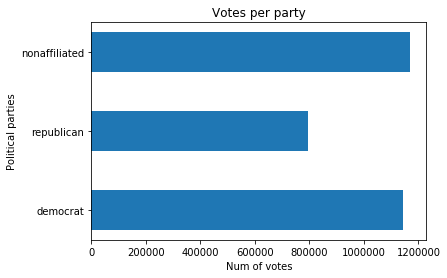

In [18]:
import statistics
from numpy import arange
num_cols = ['democrat', 'republican', 'nonaffiliated']
bar_widths = sum(cleaned[num_cols].values)
bar_positions = arange(3) + 1
tick_positions = range(1,4)

fig, ax = plt.subplots()
ax.barh(bar_positions, bar_widths, 0.5)
ax.set_yticks(tick_positions)
ax.set_yticklabels(num_cols)
ax.set_xlabel("Num of votes")
ax.set_ylabel("Political parties")
plt.title("Votes per party")
plt.show()

We can see that Non-affiliated voters have the most amount of votes, as well as the most districts where it's dominant. On the other hand, we can see that Democrats have the second highest amount of votes in total, but have the least amount of districts where it's dominant. This shows that Democrat voters are more concentrated in certain districts. We can see this by looking at the map and comparing the view with total voters with the view with dominant parties.

However, there are differences in the amount of voters per district, meaning that some districts with a high total number of voters can have a higher weight in relation to the total amount of votes per party.

If we want to avoid this, and we want that all districts have the same weight regarding the number of voters, we need to normalized the data. Normalizing it means that we will divide the number of votes per party of each district by the total amount of voters per district.

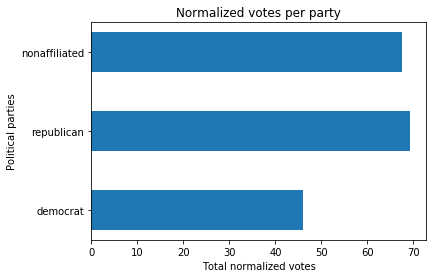

In [19]:
from numpy import arange
num_cols = ['democrat', 'republican', 'nonaffiliated']
normalized = cleaned[num_cols].div(cleaned['voter_count'], axis=0)
bar_widths = sum(normalized[num_cols].values)
bar_positions = arange(3) + 1
tick_positions = range(1,4)

fig, ax = plt.subplots()
ax.barh(bar_positions, bar_widths, 0.5)
ax.set_yticks(tick_positions)
ax.set_yticklabels(num_cols)
ax.set_xlabel("Total normalized votes")
ax.set_ylabel("Political parties")
plt.title("Normalized votes per party")
plt.show()


When looking at the total amount of normalized votes, we see that Republicans are on top despite having the lowest amount of total votes. This indicates that Republican voters dominate in districts with a low total number of voters.

We can clearly see this on the map when we switch the view from 'Voters' to 'Affiliation': on the east side of Oregon, almost all districts have a dominance of Republican votes but also a low amount of total voters (most <1000 or even <500).

There is also a geographical distribution of the votes, as mentioned above, where Republicans dominate on the east side and Non-affiliates on the west side. Democrats seem to be more distributed overall but are only present on the west half of Oregon. 
The west side of Oregon has also a higher amount of voters than the east side.

## Conclusions (tl;dr)

  - Non-affiliated voters dominate in more districts than the other parties, while Democrates dominate in the fewest amount of districts.
  - Despite dominating in only a few districts, democrats voters are concentrated in those districts, making it the second party with the highest total voters.
  - Republican voters are predominant in districts with a low number of total voters.
  - Republicans dominate on the east side of Oregon and Non-affiliates on the west side.
  - The gender ratio of voters is very equally distributed but there are, on average, more male voters than female voters per district.
  - Most voters are on the age range of 50 - 55 years old.